In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
temp_data_train = pd.read_csv('../Data/train_data.csv')
temp_data_test = pd.read_csv('../Data/test_data.csv')
# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date'] = pd.to_datetime(temp_data_test['date'])

T_actual_train = temp_data_train['mean'].to_numpy()
T_actual_test = temp_data_test['mean'].to_numpy()

temp_data_test.head()

,date,mean,max,min
0,2024-04-01,10.33,20.39,3.61
1,2024-04-02,13.22,24.22,4.50
2,2024-04-03,14.72,24.39,3.72
3,2024-04-04,12.28,24.22,5.11
4,2024-04-05,8.22,16.89,3.50


Linear and Seasonal forecast

In [4]:
# Forecast horizon
forecast_end = 365

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date = temp_data_test['date'].iloc[0]
date_range = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t = len(temp_data_train)  # assuming daily data with t = 0,1,...,N
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

# Dummy trend model (replace with real coefficients)
intercept, slope = 16.72181, 0.00002
forecast_df['trend'] =  slope * forecast_df['t']

# View the first few rows
print(forecast_df.head())

        date      t    trend seasonal forecast  actual
0 2024-04-01  33287  0.66574      NaN      NaN   10.33
1 2024-04-02  33288  0.66576      NaN      NaN   13.22
2 2024-04-03  33289  0.66578      NaN      NaN   14.72
3 2024-04-04  33290  0.66580      NaN      NaN   12.28
4 2024-04-05  33291  0.66582      NaN      NaN    8.22


In [5]:
def forecast_seasonal(t, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    C, a1, phi1, a2, phi2, a3, phi3, a4, phi4 = fitted_params
    p1, p2, p3 = 365, 730, 1460
    p4 = 2920  # ~8 years modulation period
    
    modulated = a4 * (1 + np.sin(2 * np.pi * (t - phi4) / p4)) * np.sin(2 * np.pi * t / 365)

    return C + (
        a1 * np.sin(2 * np.pi * (t - phi1) / p1) +
        a2 * np.sin(2 * np.pi * (t - phi2) / p2) +
        a3 * np.sin(2 * np.pi * (t - phi3) / p3) +
        modulated
    )

t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [16.7298,  # C
                7.155,  87.12,    # a1, phi1
                0.293, 217.87,    # a2, phi2
                0.090, 80.91,   # a3, phi3
                -0.229, 423.14]         # Add your fitted a4, phi4 values

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)
print(seasonal_forecast[:10])  # Print first 10 values of seasonal forecast
# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

forecast_df['seasonal']

[14.64409834 14.7600924  14.87670806 14.99391056 15.11166501 15.22993631
 15.34868923 15.46788839 15.58749825 15.70748315]


0      14.644098
1      14.760092
2      14.876708
3      14.993911
4      15.111665
         ...    
360    13.658814
361    13.773770
362    13.889544
363    14.006101
364    14.123407
Name: seasonal, Length: 365, dtype: float64

In [6]:
def forecast_sigmaboy(t_future, fitted_params):
    """
    Forecast seasonal variance using fitted sinusoidal model
    
    Parameters:
    t_future: array-like, future time points to forecast
    fitted_params: list or array containing [a1, phi1, a2, phi2, a3, phi3, a4, phi4]
    
    Returns:
    array of forecasted seasonal values
    """
    c0, a1, b1, a2, b2, a3, b3, a4, b4 = fitted_params
    
    # Calculate each component
    return (c0 + a1 * np.cos(2 * np.pi * 1 * t_future / 365) + b1 * np.sin(2 * np.pi * 1 * t_future / 365) +
          a2 * np.cos(2 * np.pi * 2 * t_future / 365) + b2 * np.sin(2 * np.pi * 2 * t_future / 365) +
          a3 * np.cos(2 * np.pi * 3 * t_future / 365) + b3 * np.sin(2 * np.pi * 3 * t_future / 365) +
          a4 * np.cos(2 * np.pi * 4 * t_future / 365) + b4 * np.sin(2 * np.pi * 4 * t_future / 365))

figa = forecast_df['date'].iloc[0].dayofyear
t_future = np.arange(figa, figa + forecast_end + 1)

# Your fitted parameters from the model
fitted_params = [12.3412, -0.0104,                  # c0, a1
                -0.7458, -0.7700,                   # b1, a2
                -1.0778, 1.0064,                    # b2, a3
                0.7984, -0.2430, -0.6931]           # b3, a4, b4

# Generate forecast
sigmaboy_sq = forecast_sigmaboy(t_future, fitted_params)

sigmaboy = np.sqrt(sigmaboy_sq)

# Add volatility forecast to the forecast dataframe
forecast_df['sigmaboy'] = sigmaboy[:forecast_end]

forecast_df['sigmaboy']


0      3.369849
1      3.376490
2      3.383510
3      3.390908
4      3.398684
         ...   
360    3.342182
361    3.346998
362    3.352165
363    3.357691
364    3.363584
Name: sigmaboy, Length: 365, dtype: float64

In [7]:
print(forecast_df.head())

        date      t    trend   seasonal forecast  actual  sigmaboy
0 2024-04-01  33287  0.66574  14.644098      NaN   10.33  3.369849
1 2024-04-02  33288  0.66576  14.760092      NaN   13.22  3.376490
2 2024-04-03  33289  0.66578  14.876708      NaN   14.72  3.383510
3 2024-04-04  33290  0.66580  14.993911      NaN   12.28  3.390908
4 2024-04-05  33291  0.66582  15.111665      NaN    8.22  3.398684


Random shocks (eps) for path 1: [ 1.64431578  0.08349899 -0.15997088 ... -1.91410132  0.12805641
  0.08741972]
Path 1: Previous Value: [8.67 8.67 8.67 ... 8.67 8.67 8.67], Forecast: [15.3702285  10.11051164  9.29005496 ...  3.37890031 10.26066343
 10.12372392]
Forecast for time step 1: 3.376490148846331
Forecast for time step 1: 1.999999999990898e-05
Forecast for time step 1: 0.11599406715887639
Forecast for time step 1: [1.0431186 1.0431186 1.0431186 ... 1.0431186 1.0431186 1.0431186]
Forecast for time step 1: [ 1.09468678  0.05558862 -0.10649902 ... -1.27429381  0.08525227
  0.0581988 ]
Forecast for time step 1: [ 24.27025279   1.23245275  -2.361185   ... -28.25231228   1.89012443
   1.29032313]
Random shocks (eps) for path 2: [ 1.29276664  0.74087749  1.88056585 ... -0.33092662  0.38276127
 -0.30406513]
Path 2: Previous Value: [15.3702285  10.11051164  9.29005496 ...  3.37890031 10.26066343
 10.12372392], Forecast: [19.86061648 13.56375288 16.72033646 ...  4.27074166 12.48113991
 10

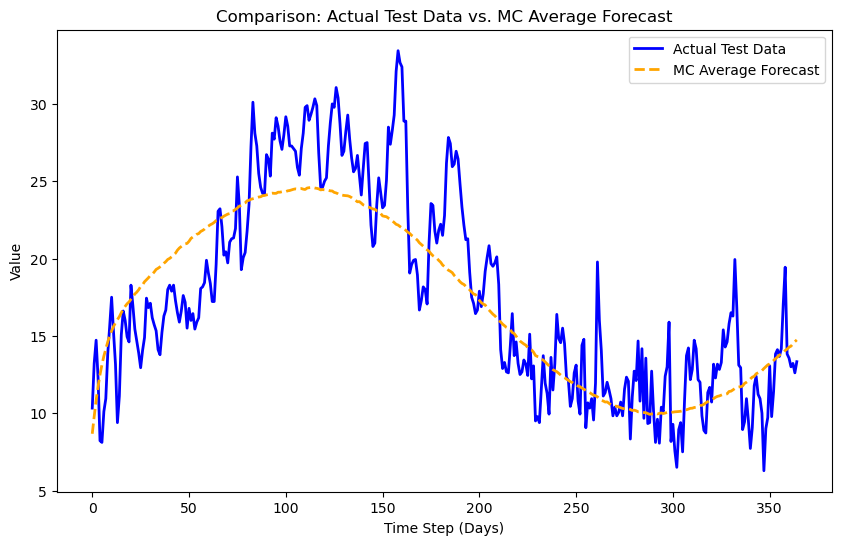

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k = -0.1571                           # Fixed speed of mean reversion (a scalar)
n_paths = 10000   # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path  # Debugging line to check random shocks
    print(f"Random shocks (eps) for path {t}: {eps}")  # Debugging line to check random shocks
    previous_value = T_all[:, t-1]

    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )
    
    print(f"Path {t}: Previous Value: {previous_value}, Forecast: {T_all[:, t]}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {forecast_df['sigmaboy'].iloc[t]}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1]}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1])}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {forecast_df['trend'].iloc[t-1]*eps}")  # Debugging line to check forecast values
    print(f"Forecast for time step {t}: {forecast_df['seasonal'].iloc[t]*eps}")  # Debugging line to check forecast values
# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()

In [9]:
print(np.isnan(T_actual_test).sum())  # Number of NaNs in T_actual_test
print(np.isnan(T_avg).sum())          # Number of NaNs in T_avg

0
0


Mean Absolute Error (MAE): 1.3751740711135276
Mean Squared Error (MSE): 3.258465338590218
Root Mean Squared Error (RMSE): 1.8051219733276247
Correlation Coefficient: 0.9614671622096771


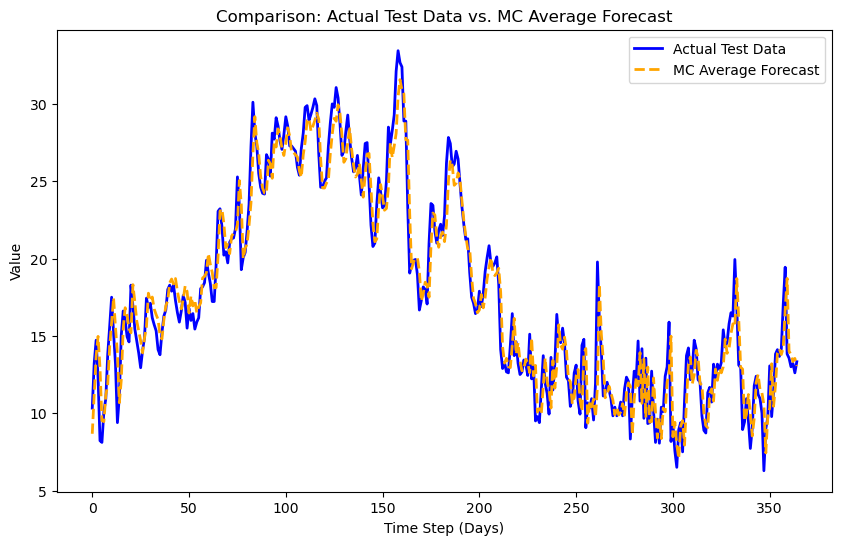

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

k = -0.1571                           # Fixed speed of mean reversion (a scalar)

n_paths = 1000000     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + k * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()